#Importing the traffic sign dataset from bit bucket

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)


#List of files in the german_traffic_signs folder

In [ ]:
!ls german-traffic-signs

#Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

#Loading Pickle files and splitting the data features and labels

In [ ]:
np.random.seed(0)

#loading the train.p pickle file
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)

#loading the valid.p pickle file
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

# loading the test.p pickle file
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
     
        
# Splitting out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
     
print("The dimensions of x_train is:",X_train.shape)
print("The dimensions of x_test is:",X_test.shape)
print("The dimensions of x_val is:",X_val.shape)

  

#visualizing the traffic signs with their class names 

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
      
num_of_samples=[]
     
cols = 5
num_classes = 43
     
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
     
for i in range(cols):
  for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
           axs[j][i].set_title(str(j) + " - " + row["SignName"])
           num_of_samples.append(len(x_selected))

#visualizing the distribution of signs in each class on bar chart

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

#Data preprocessing

In [ ]:
import cv2
     
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [ ]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

#Preprocessing X_train,X_test,X_val data

(34799, 32, 32)


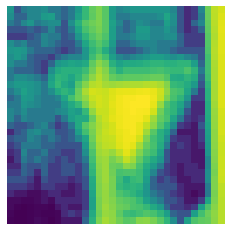

In [ ]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
     
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)



#Reshaping the preprocessed data

In [ ]:

X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

#Data Augmentation

the X_batch shape is: (15, 32, 32, 1)


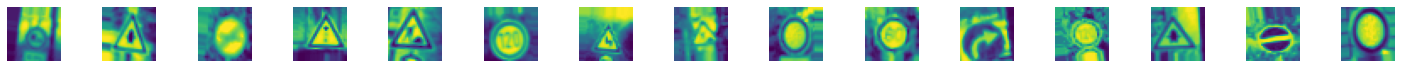

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
     
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
     
datagen.fit(X_train)


batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
     
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
     
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
     
print("the X_batch shape is:",X_batch.shape)

#Encoding the Labels and creating the model

In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

# create model
     
def modified_model():
   model = Sequential()
   model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
   model.add(Conv2D(60, (5, 5), activation='relu'))
   model.add(Conv2D(60, (5, 5), activation='relu'))
   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(Conv2D(30, (3, 3), activation='relu')) 
   model.add(Conv2D(30, (3, 3), activation='relu'))
   model.add(Conv2D(30, (3, 3), activation='relu'))
   model.add(MaxPooling2D(pool_size=(2, 2)))
      
   model.add(Flatten())
   model.add(Dense(500, activation='relu'))
   model.add(Dropout(0.5))
   model.add(Dense(43, activation='softmax'))
      
   model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
   return model

#Training the model and visualizing the model parameters

In [ ]:
model = modified_model()
print(model.summary())
     
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                              steps_per_epoch=X_train.shape[0]/50,
                              epochs=15,
                              validation_data=(X_val, y_val), shuffle = 1)

#Visualizing the loss and val_loss

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

#Visualizing the training and test accuracy

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

#Testing the model with single image

In [ ]:
import requests
from PIL import Image

#slippery road sign url link
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'

#speeed limit 30kmph sign url link
#url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'

#Yield sign url link
#url='https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'

r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
#plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
 
print("predicted sign: "+ str(model.predict_classes(img)))
classNo=int(model.predict_classes(img))

def getCalssName(classNo):
  if   classNo == 0: return 'Speed Limit 20 km/h'
  elif classNo == 1: return 'Speed Limit 30 km/h'
  elif classNo == 2: return 'Speed Limit 50 km/h'
  elif classNo == 3: return 'Speed Limit 60 km/h'
  elif classNo == 4: return 'Speed Limit 70 km/h'
  elif classNo == 5: return 'Speed Limit 80 km/h'
  elif classNo == 6: return 'End of Speed Limit 80 km/h'
  elif classNo == 7: return 'Speed Limit 100 km/h'
  elif classNo == 8: return 'Speed Limit 120 km/h'
  elif classNo == 9: return 'No passing'
  elif classNo == 10: return 'No passing for vechiles over 3.5 metric tons'
  elif classNo == 11: return 'Right-of-way at the next intersection'
  elif classNo == 12: return 'Priority road'
  elif classNo == 13: return 'Yield'
  elif classNo == 14: return 'Stop'
  elif classNo == 15: return 'No vechiles'
  elif classNo == 16: return 'Vechiles over 3.5 metric tons prohibited'
  elif classNo == 17: return 'No entry'
  elif classNo == 18: return 'General caution'
  elif classNo == 19: return 'Dangerous curve to the left'
  elif classNo == 20: return 'Dangerous curve to the right'
  elif classNo == 21: return 'Double curve'
  elif classNo == 22: return 'Bumpy road'
  elif classNo == 23: return 'Slippery road'
  elif classNo == 24: return 'Road narrows on the right'
  elif classNo == 25: return 'Road work'
  elif classNo == 26: return 'Traffic signals'
  elif classNo == 27: return 'Pedestrians'
  elif classNo == 28: return 'Children crossing'
  elif classNo == 29: return 'Bicycles crossing'
  elif classNo == 30: return 'Beware of ice/snow'
  elif classNo == 31: return 'Wild animals crossing'
  elif classNo == 32: return 'End of all speed and passing limits'
  elif classNo == 33: return 'Turn right ahead'
  elif classNo == 34: return 'Turn left ahead'
  elif classNo == 35: return 'Ahead only'
  elif classNo == 36: return 'Go straight or right'
  elif classNo == 37: return 'Go straight or left'
  elif classNo == 38: return 'Keep right'
  elif classNo == 39: return 'Keep left'
  elif classNo == 40: return 'Roundabout mandatory'
  elif classNo == 41: return 'End of no passing'
  elif classNo == 42: return 'End of no passing by vechiles over 3.5 metric tons'

sign=getCalssName(classNo)
print("the detected sign is {}".format(sign))